# Bayesian meta-analysis of two proportions in random control trials (RCTs)
---

This notebook shows how to perform a specific type of meta-analysis in Python/PyMC. The example is adapted from John Kruschke, who originally implemented this analysis in R. Here are links to his [blog entry](http://doingbayesiandataanalysis.blogspot.com/2016/11/bayesian-meta-analysis-of-two.html) and [article](https://link.springer.com/article/10.3758/s13423-016-1221-4).

In this example, we are interested in the number of deaths ("occurrences of mortality") from heart attack in a control group and a treatment group that were "treated" with beta-blockers (a class of drugs that relaxes heart muscles). Let $z_T$ denote the number of occurrences in the treatment group, $n_T$ denote the total number of participants in the treatment group, and $z_C$ and $n_C$ denote the same for the controls. If beta-blockers have a beneficial effect, then $z_T/n_T$ should be less than $z_C/n_C$. 

In a meta-analysis, we are combining information (data) from several studies examining the same phenomenon in order to make better inferences. The data from study $s$ are denoted $z_{C[s]}$, $n_{C[s]}$, etc. The key insight is that even though we don't expect the proportions of occurrences to be the identical across different studies/sites, as each site has its own attributes, we do expect the studies to be similar and mutually informative. That is, we expect Study A to tell us something about Study B, and vice versa. This means we should treat the data from different sites as representative of higher-level parameters that describe what is typical across sites and how much variability there is across sites. This approach is referred to as a **random-effects model**. Here are the equations for this model, starting with the likelihoods in the first two lines:

$$z_C \sim \text{Binomial}(\theta_{C[s]}, n_{C[s]})$$
$$z_T \sim \text{Binomial}(\theta_{T[s]}, n_{T[s]})$$
$$\theta_{C[s]} \sim \text{Beta}(\omega_{\theta C})$$
$$\theta_{T[s]} = \text{logistic}(\rho_s + \text{logit}(\theta_{C[s]}))$$
$$\rho_{s} \sim \text{Normal}(\mu_{\rho}, \sigma_{\rho}^2)$$
$$\mu_{\rho} \sim \text{Normal}(0, 100)$$
$$\sigma_{\rho} \sim \text{Gamma}(\alpha=1.64, \beta=0.64)$$

Here, $\rho_s$ is the difference of log-odds between groups, or, the *log odds ratio* across groups: $\rho_s = \text{log}([\theta_{T[s]}/(1 - \theta_{T[s]})]/[\theta_{C[s]}/(1 - \theta_{C[s]})]$. The distribution across $\rho_s$ is described by a normal distribution, parameterized by its mean and SD. Therefore, what we are most interested in is $\mu_{\rho}$, the estimated treatement effect across studies. ***Check out the links I've provided for more details.*** 

The data we will model are from 22 studies, involving anywhere between 77 and 3,887 patients. The are described in Gelamn et al.'s *Bayesian Data Analysis, Third Edition*. The treatment group received beta-blockers. If the treatment is effective, the log odds ratio will be less than zero. 

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'
# az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95
rng = np.random.default_rng(seed=42)

In [3]:
# Data from 22 studies
z_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
z_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]

# We will "name" each study to provide study labels to parameters
# in our summary plots
N = len(n_c_obs)
study = []
for x in range(N):
    study.append("study" + str(x+1))

# Create dataframe
df = pd.DataFrame(
    {"z_t_obs": z_t_obs, 
    "n_t_obs": n_t_obs,
    "z_c_obs": z_c_obs,
    "n_c_obs": n_c_obs,
    "study": study}
)


In [4]:
def meta_binary_outcome(z_t_obs, n_t_obs, z_c_obs, n_c_obs, study, n_draws=1000):
    """Fits multi-level meta-analysis model of binary outcomes.
    
    Args:
        z_t_obs: number of occurrences in treatment group
        n_t_obs: number of opportunities/participants in treatment gruops
        z_c_obs: number of occurrences in control group
        n_c_obs: number of opportunities/participants in control group
        study: list of studies included in analysis
   
   Returns:
       PyMC model and InferenceData objects.
    """

    with pm.Model(coords={"study": study}) as model:  

        # Hyper-priors
        mu_rho = pm.Normal("mu_rho", mu=0, sigma=10)
        sigma_rho = pm.Gamma("sigma_rho", alpha=1.64, beta=0.64)  # mode=1, sd=2

        omega_theta_c = pm.Beta("omega_theta_c", alpha=1.01, beta=1.01)
        kappa_minus_two_theta_c = pm.Gamma("kappa_minus_two_theta_c", alpha=2.618, beta=0.162)  # mode=10, sd=10
        kappa_theta_c = pm.Deterministic("kappa_theta_c", kappa_minus_two_theta_c + 2)

        # Priors
        rho = pm.Normal("rho", mu=mu_rho, sigma=sigma_rho, dims="study")
        theta_c = pm.Beta("theta_c", alpha=omega_theta_c * (kappa_theta_c - 2) + 1, 
                          beta=(1 - omega_theta_c) * (kappa_theta_c - 2) + 1, dims="study")
        theta_t = pm.Deterministic("theta_t", pm.invlogit(rho + pm.logit(theta_c)))  # ilogit is logistic

        # Likelihood
        z_t = pm.Binomial('z_t', n_t_obs, theta_t, observed=z_t_obs)
        z_c = pm.Binomial('z_c', n_c_obs, theta_c, observed=z_c_obs)

        # Sample from the posterior
        idata = pm.sample(draws=n_draws, target_accept=0.90)

        return model, idata

In [5]:
model, idata = meta_binary_outcome(z_t_obs, n_t_obs, z_c_obs, n_c_obs, study)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_rho, sigma_rho, omega_theta_c, kappa_minus_two_theta_c, rho, theta_c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


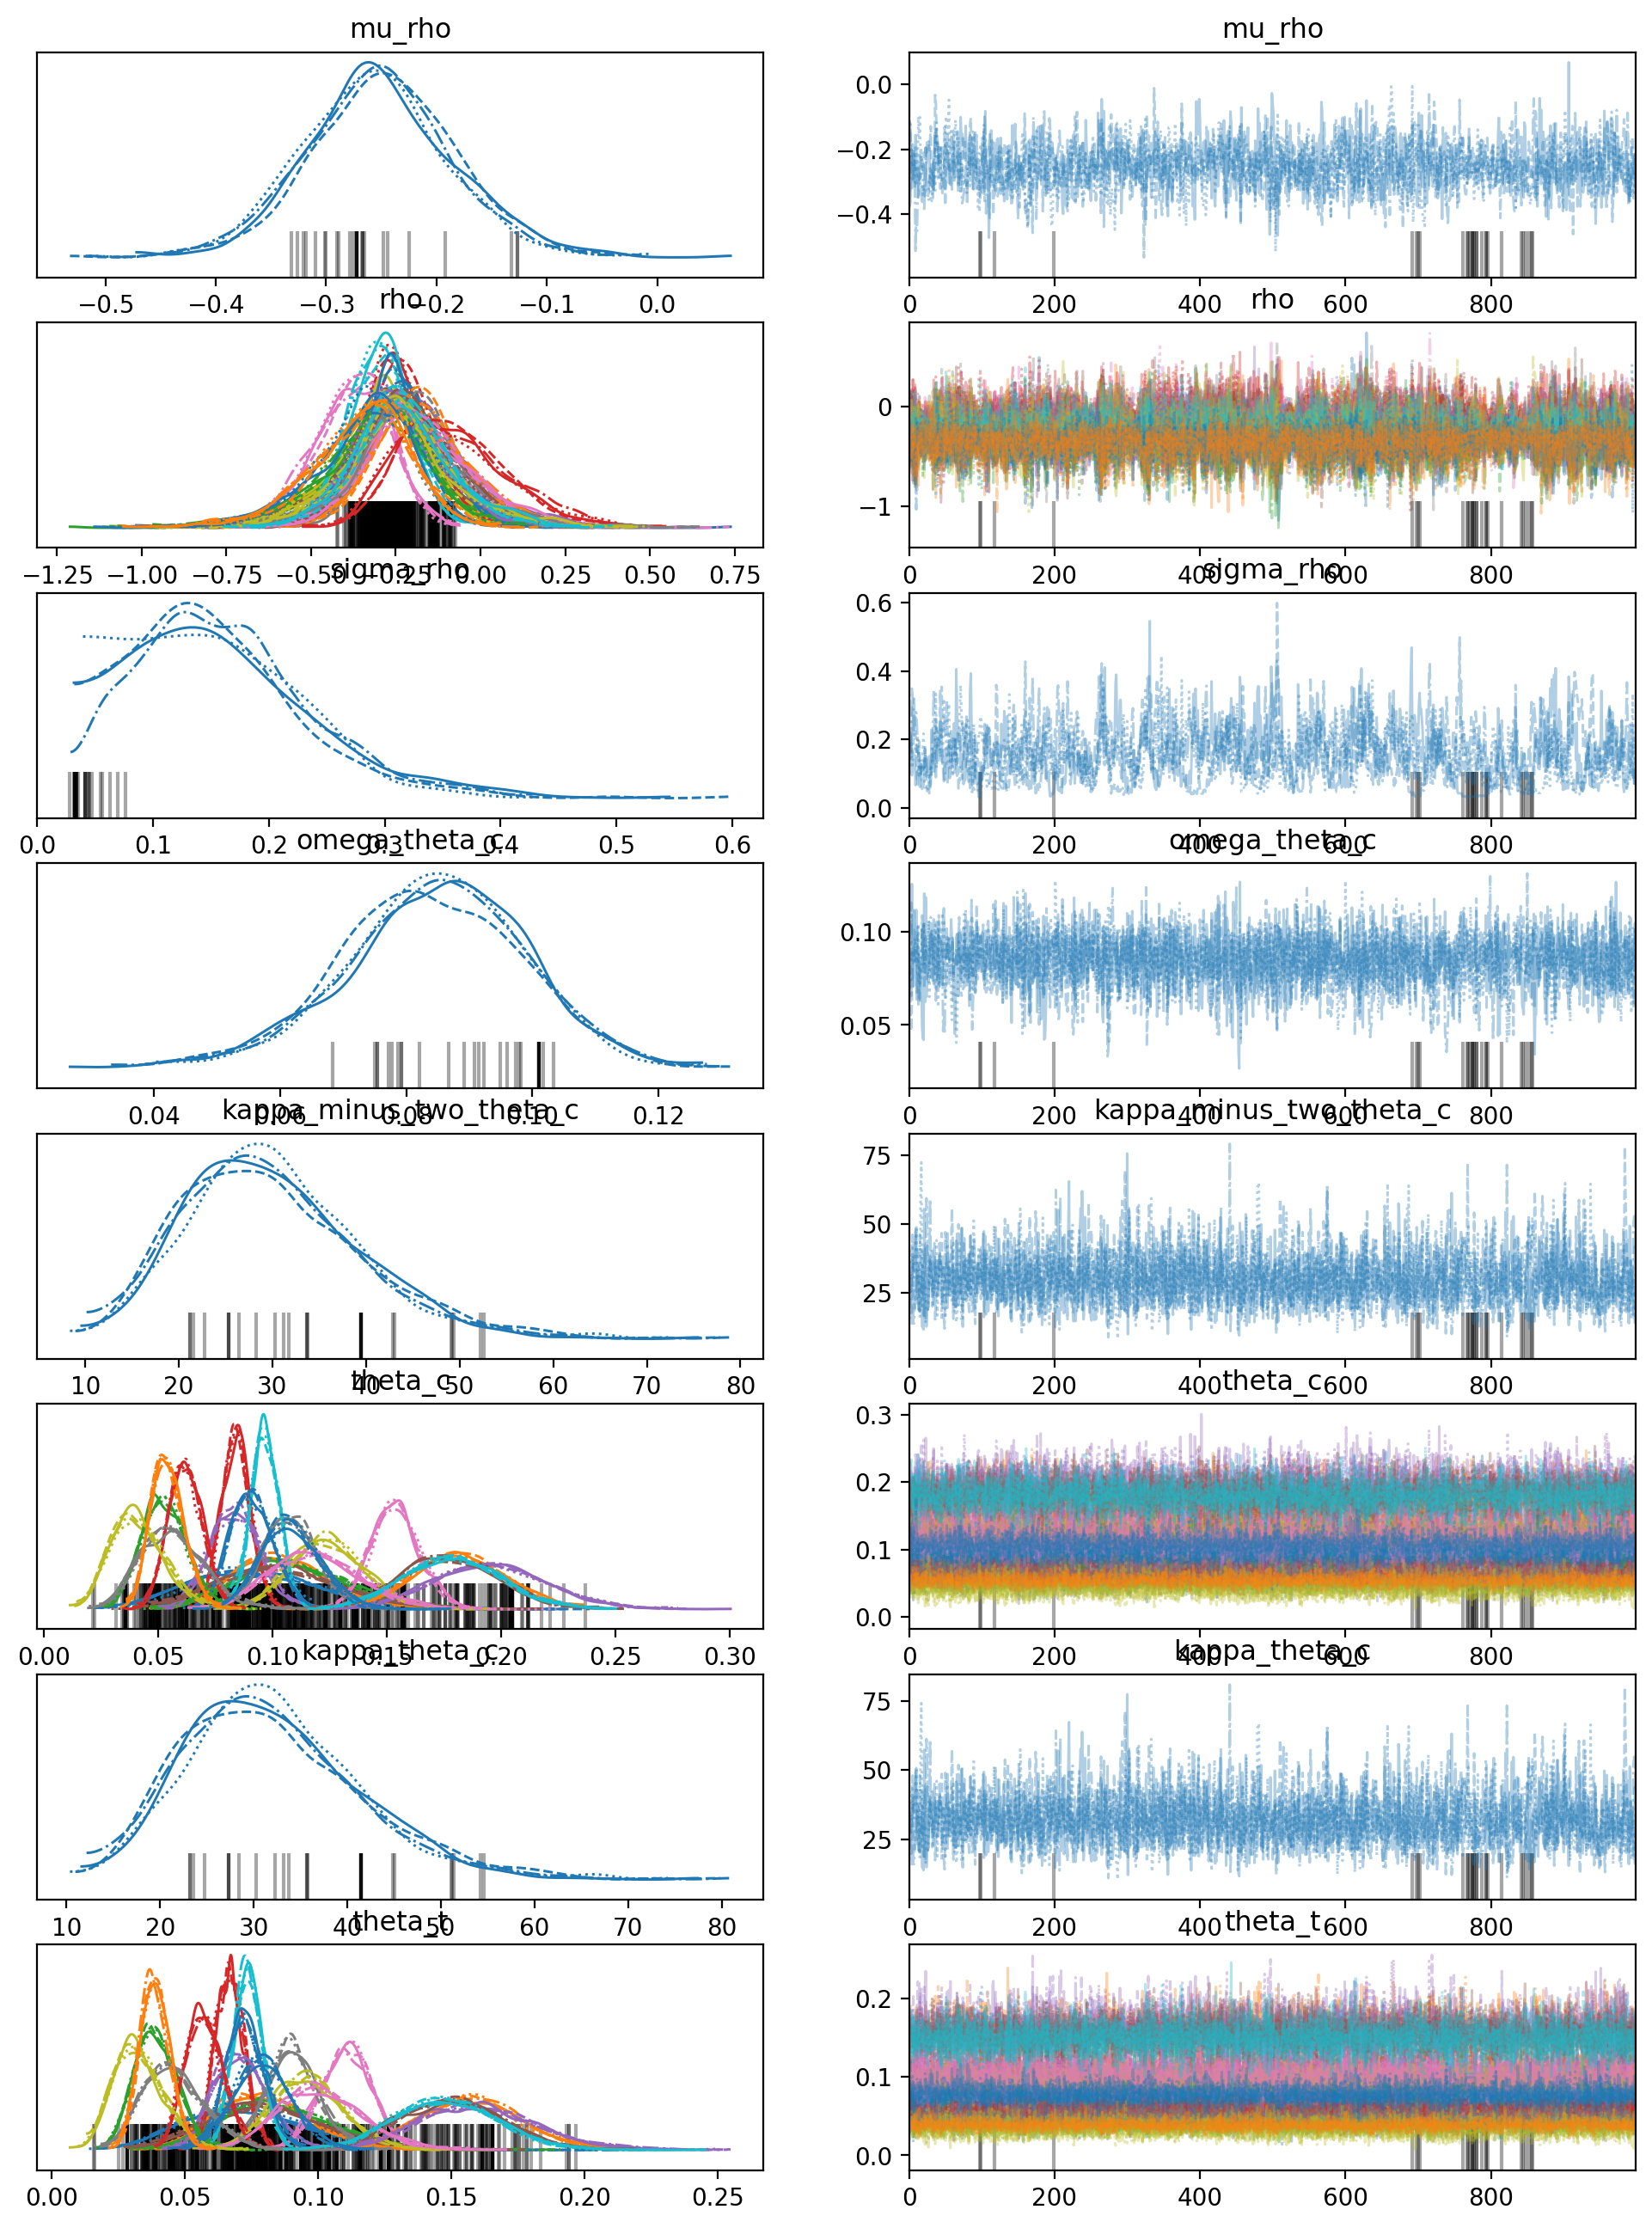

In [6]:
az.plot_trace(idata);

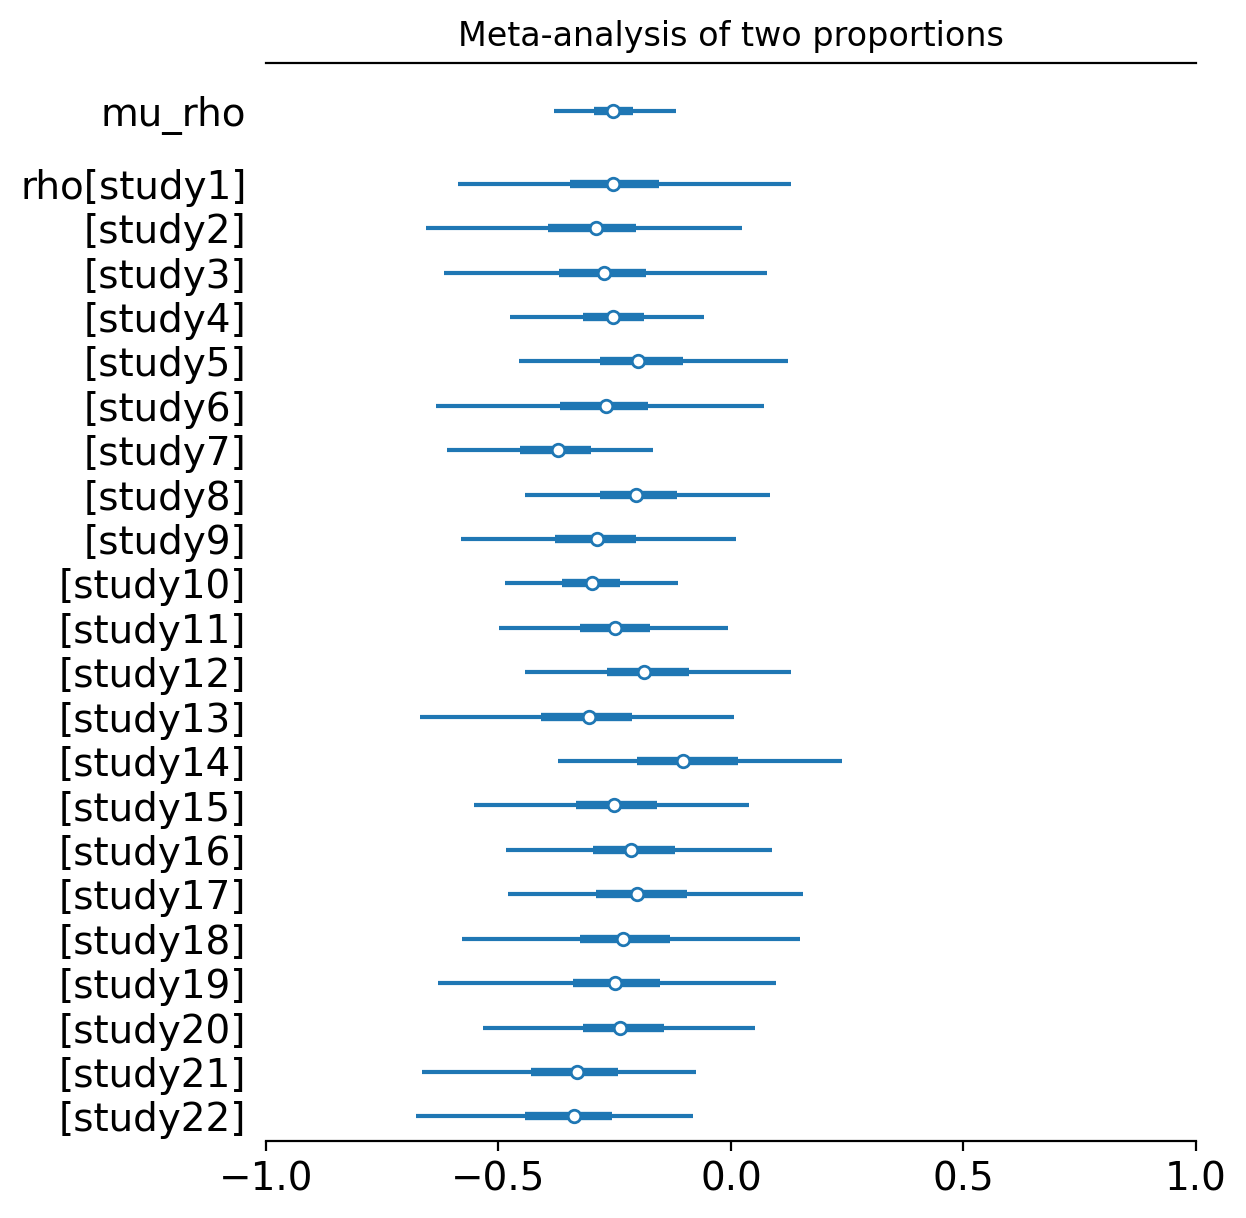

In [7]:
_, ax = plt.subplots(figsize=(6, 7))
az.plot_forest(idata, 
               var_names=["mu_rho", "rho"], 
               kind="forestplot",
               combined=True,
               ax=ax)
ax.set_xlim([-1, 1])
ax.set_title("Meta-analysis of two proportions");

In [8]:
az.summary(idata, var_names=["mu_rho", "rho"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_rho,-0.252,0.067,-0.380,-0.119,0.002,0.001,1179.0,2040.0,1.0
rho[study1],-0.249,0.172,-0.586,0.129,0.003,0.003,2687.0,2050.0,1.0
rho[study2],-0.304,0.165,-0.655,0.025,0.003,0.003,2574.0,2745.0,1.0
rho[study3],-0.277,0.168,-0.618,0.078,0.003,0.003,2757.0,2430.0,1.0
rho[study4],-0.253,0.105,-0.474,-0.057,0.002,0.001,2616.0,3163.0,1.0
rho[study5],-0.187,0.145,-0.456,0.123,0.004,0.003,1596.0,1927.0,1.0
rho[study6],-0.276,0.171,-0.635,0.070,0.003,0.003,2933.0,1846.0,1.0
rho[study7],-0.381,0.113,-0.610,-0.167,0.003,0.002,1140.0,1996.0,1.0
rho[study8],-0.194,0.132,-0.442,0.083,0.003,0.002,1711.0,2214.0,1.0
rho[study9],-0.295,0.145,-0.581,0.011,0.003,0.002,2476.0,1766.0,1.0


The estimated parameter values above are highly consistent with those reported in the Kruschke analysis using R and JAGS.